In [1]:
import operator
import math
import random

import numpy as np
from scipy import linalg

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import pickle
from datetime import datetime


from evaluate_fixed import Collocation2D,Collocation3D, Circle, StarLikeCurve, Sphere, StarLikeSurface, BoundaryCondition, MFSHelper2D, MFSHelper3D


# General configuration

In [2]:
DIM_2D = True # 2D - True, 3D - False

In [3]:
N = 256 # number of collocation points to calculate boundary data
Nstep = 4 # specify division step.
assert N % Nstep == 0

In [4]:
G1_DIRICHLET_COND = BoundaryCondition(lambda X: np.zeros(shape=(X.shape[1],1), dtype=float)) ## Dirichlet condition
G2_NEUMAN_COND = BoundaryCondition(lambda X: np.ones(shape=(X.shape[1],1), dtype=float)*3) ## Neuman condition

In [5]:
EXTERIOR_BOUNDARY_RADIUS = 5

In [6]:
EPS = 1e-15

In [7]:
RAND_CONST_MIN = -100
RAND_CONST_MAX = 100

In [8]:
NOISE_LEVEL = 0.02 # 2% of noise
# TODO: add noise

### Radial function for interior boundary

In [9]:
if DIM_2D:
    R_EXACT = lambda t: 2 + math.sin(t)*(0.1 + math.cos(3*t))
#     R_EXACT = lambda t: 2*math.sqrt(math.cos(t)**2 + math.sin(t)**2/4)
else:
    R_EXACT = lambda theta, phi: 2 +  math.sqrt(4.25 + 3*math.cos(3*theta))
#     R_EXACT = lambda theta, phi: 2*math.sqrt(math.cos(2*theta)+ math.sqrt(2 - math.sin(2*theta)**2))

R_EXACT = np.vectorize(R_EXACT)

# Define test boundaries and calculate boundary values

In [10]:
if DIM_2D:
    collocation = Collocation2D(N)
else:
    collocation = Collocation3D(N)

### Define exterior boundary

In [11]:
if DIM_2D:
    G2_BOUNDARY = Circle(collocation, EXTERIOR_BOUNDARY_RADIUS)
    G2_VALUES = G2_BOUNDARY()
    G1_BOUNDARY = StarLikeCurve(collocation)
    G1_VALUES = G1_BOUNDARY(R_EXACT(collocation.thetas)) # Values in collocation points
else:
    G2_BOUNDARY = Sphere(collocation, EXTERIOR_BOUNDARY_RADIUS)
    G2_VALUES = G2_BOUNDARY()
    G1_BOUNDARY = StarLikeSurface(collocation)
    G1_VALUES = G1_BOUNDARY(R_EXACT(collocation.thetas, collocation.phis)) # Values in collocation points

In [12]:
if DIM_2D:
    HELPER = MFSHelper2D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND)
else:
    HELPER = MFSHelper3D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND)

## Find the Dirichlet data on Gamma2

In [13]:
A = HELPER.form_matrix(G1_VALUES.copy()) # A = (2NxN)
b = HELPER.form_column(G1_VALUES.copy())
lambda_ = linalg.lstsq(A,b)[0]

In [14]:
G2_DIRICHLET_VALUES = HELPER.uApprox(lambda_, G2_VALUES.copy(), G1_VALUES.copy())

## Recalculate data

In [15]:
N = int(N/Nstep)

In [16]:
if DIM_2D:
    collocation = Collocation2D(N)
else:
    collocation = Collocation3D(N)

In [17]:
if DIM_2D:
    G2_BOUNDARY = Circle(collocation, EXTERIOR_BOUNDARY_RADIUS)
    G2_VALUES = G2_BOUNDARY()
    G1_BOUNDARY = StarLikeCurve(collocation)
    G1_VALUES = G1_BOUNDARY(R_EXACT(collocation.thetas))
else:
    G2_BOUNDARY = Sphere(collocation, EXTERIOR_BOUNDARY_RADIUS)
    G2_VALUES = G2_BOUNDARY()
    G1_BOUNDARY = StarLikeSurface(collocation)
    G1_VALUES = G1_BOUNDARY(R_EXACT(collocation.thetas, collocation.phis)) # Values in collocation points

In [18]:
if DIM_2D:
    HELPER = MFSHelper2D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND)
    G2_DIRICHLET_VALUES = G2_DIRICHLET_VALUES[0:len(G2_DIRICHLET_VALUES)-1:Nstep]
else:
    HELPER = MFSHelper3D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND)
    G2_DIRICHLET_VALUES = G2_DIRICHLET_VALUES[0:len(G2_DIRICHLET_VALUES)-1:Nstep]

## Define the evaluation function

### 2D

In [19]:
def feasible2D(individual, thetas, curvature_threshold):
    """Feasibility function for the individual. Returns True if feasible False
    otherwise."""
    ## evaluate function values
    func_vect = np.vectorize(toolbox.compile(expr=individual))
    
    try:
        f_vals = func_vect(thetas)*individual.scale
    except Exception as e:
        return False
    
    ## Save calculated values to evaluate the error or distance
    individual.eval_values = f_vals[:-1]
    
    ## Check if all values are finite
    if not np.isfinite(f_vals).all():
        return False
    
    ## Singular boundary
    if (abs(f_vals) < EPS).all(): 
        return False
    
    ## Interior boundary has to be inside outter boundary
    if not (abs(f_vals) < EXTERIOR_BOUNDARY_RADIUS).all():
        return False
    
    ## Check if function is periodic
    if abs(f_vals[0] - f_vals[-1]) > EPS:
        return False
    
#     ## check curvature
#     g1_approx_values = G1_BOUNDARY(individual.eval_values)
#     dx_dt = np.gradient(g1_approx_values[0])
#     dy_dt = np.gradient(g1_approx_values[1])
#     ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)
#     d2s_dt2 = np.gradient(ds_dt)
#     d2x_dt2 = np.gradient(dx_dt)
#     d2y_dt2 = np.gradient(dy_dt)

#     curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
    
#     if (curvature > curvature_threshold).any():
#         return False
    
    return True

In [20]:
def distance2D(individual):
    """A distance function to the feasibility region."""
    return 1e3 # TODO: add not const distance function

In [21]:
def eval2D(individual):    
    g1_approx_values = G1_BOUNDARY(individual.eval_values)
    
#     individual.error_values = G1_VALUES - g1_approx_values
#     return linalg.norm(G1_VALUES - g1_approx_values), ## Test evaluation
    
    
    A =HELPER.form_matrix(g1_approx_values.copy())
    b = HELPER.form_column(g1_approx_values.copy())
    
    try: # Sometimes got an error about zero division in log in formulas. Need to check if there is any error
        lambda_ = linalg.lstsq(A,b)[0]
    except:
        print(f"F:{individual},  vals: ",individual.eval_values)
        return 1e9,
    
    g2_dirichlet_approx = HELPER.uApprox(lambda_,HELPER.g2_coll,g1_approx_values)
    individual.error_values = G2_DIRICHLET_VALUES-g2_dirichlet_approx

    individual.last_fitness = np.sum((G2_DIRICHLET_VALUES-g2_dirichlet_approx)**2)/N ## MSE error
#     individual.last_fitness = np.sqrt((2*np.pi/N)*np.sum((G2_DIRICHLET_VALUES-g2_dirichlet_approx)**2)) ## L2 norm
    
    return individual.last_fitness,

### 3D

In [22]:
def feasible3D(individual, thetas, phis):
    """
    Feasibility function for the individual. Returns True if feasible False
    otherwise.
    
    thetas has shape (NxN) and next structure:
    
    t0  t1  t1  ...  tn
    t0  t1  t1  ...  tn
     .   .   .  ...  .
    t0  t1  t1  ...  tn
    
    phis has shape (NxN) and next structure:
    
    p0  p0  p0  ...  p0
    p1  p1  p1  ...  p1
     .   .   .  ...  .
    pn  pn  pn  ...  pn
    
    
    """    
    # Evaluate function values
    func_vect = np.vectorize(toolbox.compile(expr=individual))

    try:
        f_vals = func_vect(theta = thetas,phi = phis)*individual.scale
    except:
        return False
    
    # Save calculated values to evaluate the error or distance
    individual.eval_values = f_vals
    
    # Check if all values are finite
    if not np.isfinite(f_vals).all():
        return False
    
    # Check for singular surface
    if (abs(f_vals) < EPS).all():
        return False
    
    # Interior boundary has to be inside outter boundary
    if not (abs(f_vals) < EXTERIOR_BOUNDARY_RADIUS).all():
        return False
    
    # Check if surface is closed
    
    # r(0,phi_1) = r(0,phi_2) = ... = r(0, phi_n)
    thetas_0 = f_vals[:,0]
    if not np.isclose(thetas_0, thetas_0[0], atol=EPS).all():
        return False
    
    # r(pi,phi_1) = r(pi,phi_2) = ... = r(pi, phi_n)
    thetas_pi = f_vals[:,-1]
    if not np.isclose(thetas_pi, thetas_pi[0], atol=EPS).all():
        return False    
    
    # r(thetas,0) = r(thetas,2pi)
    if not np.allclose(f_vals[0], f_vals[-1], atol=EPS):
        return False
    
    return True

In [23]:
def distance3D(individual):
    """A distance function to the feasibility region."""
    return 1e3 # TODO: add not const distance function

In [24]:
def eval3D(individual):    
    g1_approx_values = G1_BOUNDARY(individual.eval_values.diagonal()) # take digagonal values (theta_0, phi_0), ..., (theta_n,phi_n)
    
#     return linalg.norm(G1_VALUES - g1_approx_values), # Test evaluation
    
    A =HELPER.form_matrix(g1_approx_values.copy())
    b = HELPER.form_column(g1_approx_values.copy())
    
    try: ## Sometimes got an error about zero division in log in formulas. Need to check if there is any error
        lambda_ = linalg.lstsq(A,b)[0]
    except:
#         print(f"F:{individual},  vals: ",individual.eval_values)
        return 1e9,
    
    g2_dirichlet_approx = HELPER.uApprox(lambda_,HELPER.g2_coll,g1_approx_values)
    
    individual.error_values = G2_DIRICHLET_VALUES-g2_dirichlet_approx
    individual.last_fitness = np.sum((G2_DIRICHLET_VALUES-g2_dirichlet_approx)**2)/N ## MSE error
    
    return individual.last_fitness,
#     return linalg.norm(G2_DIRICHLET_VALUES-g2_dirichlet_approx), 
#     return np.sqrt((2*np.pi/N)*np.sum((G2_DIRICHLET_VALUES-g2_dirichlet_approx)**2)),

# Configure deap

In [25]:
def protectedDiv(left, right):
    if abs(right) < 1e-5:
        return 1.0
    return operator.truediv(left, right)

In [26]:
def protectedSqrt(val):
    return math.sqrt(abs(val))

In [27]:
def pow2(val):
    return math.pow(val,2)

def pow3(val):
    return math.pow(val,2)

def pow4(val):
    return math.pow(val,2)

def pow5(val):
    return math.pow(val,2)

### Warning: since np.vectorize used in evaluation the exceptions in functions ( even handled) gives an error

In [28]:
if DIM_2D:
    pset = gp.PrimitiveSet("MAIN", 1) # in 2d radial function has only one parameter
else:
    pset = gp.PrimitiveSet("MAIN", 2) # in 3d radial function has two parameters (phi, theta)

# some binary operators
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.mul, 2)
# pset.addPrimitive(protectedPow, 2) ## TODO: check and add
# pset.addPrimitive(math.pow, 2)


# some unary operators
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(protectedSqrt, 1)

##### For test
pset.addPrimitive(pow2, 1)
pset.addPrimitive(pow3, 1)
pset.addPrimitive(pow4, 1)
pset.addPrimitive(pow5, 1)
#####

# some useful constants
pset.addTerminal(np.pi,name='pi')
pset.addTerminal(np.e,name='e')
pset.addEphemeralConstant("randUniform", lambda: random.uniform(RAND_CONST_MIN, RAND_CONST_MAX))

# rename arguments
if DIM_2D:
    pset.renameArguments(ARG0='t')
else:
    pset.renameArguments(ARG0='theta')
    pset.renameArguments(ARG1='phi')

In [29]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual",
               gp.PrimitiveTree,
               fitness=creator.FitnessMin, 
               eval_values = np.empty(N, dtype=float),
               error_values = np.empty(N, dtype=float),
               last_fitness = float,
               scale = 1.0)

In [30]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [31]:
if DIM_2D:
    toolbox.register("evaluate", eval2D)
    toolbox.register("evaluate_feasible",feasible2D, thetas = collocation.thetas_closed, curvature_threshold = 25.0)
    toolbox.decorate("evaluate", tools.DeltaPenalty(toolbox.evaluate_feasible, 1e2))
else:
    thetas_mesh, phis_mesh = collocation.mesh_closed
    toolbox.register("evaluate", eval3D)
    toolbox.register("evaluate_feasible",feasible3D, thetas = thetas_mesh, phis = phis_mesh)
    toolbox.decorate("evaluate", tools.DeltaPenalty(toolbox.evaluate_feasible, 1e10)) 

## Custom selection operators

In [32]:
from operator import attrgetter

def selectTournamentUnique(individuals, k, tournsize,best = max, fit_attr="fitness"):
    chosen = []
    while(len(chosen) < k):
        aspirants = tools.selRandom(individuals, tournsize)
        selected_best = best(aspirants, key=attrgetter(fit_attr))
        if(selected_best not in chosen):
            chosen.append(selected_best)
    return chosen

In [33]:
toolbox.register("select_tournament", tools.selTournament, tournsize=3)
toolbox.register("select_worst", tools.selWorst)

## Custom crossover operators

In [34]:
def chooseMate(ind1, ind2, operators, probs): # operators = [(operator,prob),...]
    op = np.random.choice(operators,1,probs)[0]
    return op(ind1, ind2)

In [35]:
def cxUniform(ind1, ind2, swapProb):
    if len(ind1) < 2 or len(ind2) < 2:
        # No crossover on single node tree
        return ind1, ind2
    
    idx1 = 1
    idx2 = 1
    while idx1 < len(ind1) and idx2 < len(ind2):
        if np.random.uniform() < swapProb:
            slice1 = ind1.searchSubtree(idx1)
            slice2 = ind2.searchSubtree(idx2)
            ind1[slice1], ind2[slice2] = ind2[slice2], ind1[slice1]
        idx1+=1
        idx2+=2
            
    return ind1, ind2

In [36]:
toolbox.register("mate_one_point", gp.cxOnePoint)
toolbox.register("mate_uniform", cxUniform, swapProb = 0.5)

'''
 Crossover Operator |   Apply probability
--------------------|----------------------
 One point          |         60%
 Uniform            |         40% 

'''

toolbox.register("mate",chooseMate,
                operators = (toolbox.mate_one_point,
                             toolbox.mate_uniform),
                 probs = (0.5,0.5))

## Custom mutation operators

In [37]:
def mutScale(individual, scale):
    fit = individual.last_fitness
    
    individual.scale += np.random.uniform(-scale*fit,scale*fit)
    
    return individual,


In [38]:
def mutHoist(individual):
    '''
    This operator set randomly selected subtree as a new individual
    
    '''
    # We don't want to "shrink" the root
    if len(individual) < 3 or individual.height <= 1:
        return individual,
    
    index = random.randrange(1,len(individual)) # choose random node ( not root)
    slice_ = individual.searchSubtree(index)
    return creator.Individual(individual[slice_]),

In [39]:
def mutEphemeralByFitness(individual, scale, mode):
    ephemerals_idx = [index
                      for index, node in enumerate(individual)
                      if isinstance(node, gp.Ephemeral)]
    
    if len(ephemerals_idx) > 0:
        fit = individual.last_fitness
        if mode == 'one':
            ephemerals_idx = (random.choice(ephemerals_idx),)
        
        for i in ephemerals_idx:
            individual[i].value += np.random.uniform(-scale*fit,scale*fit)
            
    return individual,

In [40]:
def mutAddConstant(individual, pset):
    if len(individual) < 3 or individual.height <= 1:
        return individual,
    
    index = random.randrange(1,len(individual)) # choose random node ( not root)
    slice_ = individual.searchSubtree(index)
    mulPrimitive = gp.Primitive(operator.mul.__name__, [object, object], object)

    individual[slice_] = [mulPrimitive] + individual[slice_] + [gp.randUniform()]# Warning: function name has to be defined in pset
    return individual,

### Apply mutate operator by specified probability

In [41]:
def chooseMutate(individual, operators,probs): # operators = [(operator,prob),...]
    op = np.random.choice(operators,1,probs)[0]
    return op(individual)

In [42]:
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
# Standart ( from 'deap' lib)
toolbox.register("mutate_uniform", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("mutate_node_replacement", gp.mutNodeReplacement, pset=pset)
toolbox.register("mutate_insert", gp.mutInsert,  pset=pset)
toolbox.register("mutate_hoist", mutHoist)

# Custom
toolbox.register("mutate_ephemeral", mutEphemeralByFitness, scale = 1e-1, mode='one')
toolbox.register("mutate_scale", mutScale, scale = 1e-2)
toolbox.register("mutate_add_const", mutAddConstant, pset=pset)

'''
  Mutation Operator |   Apply probability
--------------------|----------------------
 Uniform            |         20%
 Node replacemnet   |         20% 
 Ephemeral          |         30%
 Insert             |         10%
 Hoist              |         5%
 Add constant       |         5%
 Scale              |         10%
'''

toolbox.register("mutate",chooseMutate,
                operators = (toolbox.mutate_uniform,
                             toolbox.mutate_node_replacement,
                             toolbox.mutate_ephemeral,
                             toolbox.mutate_insert,
                             toolbox.mutate_hoist,
                             toolbox.mutate_add_const,
                             toolbox.mutate_scale),
                 probs = (0.2,0.2,0.3,0.1,0.05,0.05,0.1))

### Specify the height limits due to stack overflow error in algorithms

In [43]:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=20))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=20))

# Visualization

In [44]:
from abc import ABC, abstractmethod
class PlotInteractive(ABC):
    def __init__(self, fig, ax):
        self.fig = fig
        self.ax = ax
    @abstractmethod
    def plot_approx(self, r_approx, title):
        pass

In [45]:
class PlotInteractive2D(PlotInteractive):
    def __init__(self, fig, ax, thetas, r_exact_vals, plot_errors = False):
        super().__init__(fig, ax)
        self.thetas = thetas
        self.x = np.cos(self.thetas)
        self.y = np.sin(self.thetas)
        
        self.curve_exact = ax.plot(r_exact_vals*self.x, r_exact_vals*self.y, 'g-')
        self.curve_approx = ax.plot(self.x, self.y, 'b--')
        self.plot_errors = plot_errors
        if plot_errors:
            self.scatter_error = ax.scatter(self.x, self.y, s =10)
            self.fig.colorbar(self.scatter_error, ax= self.ax)

        
    def plot_approx(self, r_approx, errors, title):
        self.curve_approx[0].set_xdata(r_approx*self.x)
        self.curve_approx[0].set_ydata(r_approx*self.y)
        if self.plot_errors:
            self.scatter_error.remove()
            self.scatter_error = ax.scatter(r_approx*self.x, r_approx*self.y, s =20, c =errors  )
            self.fig.colorbar(self.scatter_error, ax= self.ax)

        self.ax.set_title(title)
        self.fig.canvas.draw()

In [46]:
class PlotInteractive3D(PlotInteractive):
    def __init__(self, fig, ax, thetas, phis, r_exact_vals):
        super().__init__(fig, ax)
        self.thetas = thetas
        self.phis = phis
        self.x = np.outer(np.cos(self.phis), np.sin(self.thetas))
        self.y = np.outer(np.sin(self.phis), np.sin(self.thetas))
        self.z = np.outer(np.ones(np.size(self.phis)), np.cos(self.thetas))
        self.surf_exact = ax.plot_wireframe(r_exact_vals*self.x,r_exact_vals*self.y,r_exact_vals*self.z, colors='lime')
        self.surf_approx = ax.plot_wireframe(self.x,self.y,self.z)

    def plot_approx(self, r_approx, errors, title):
        self.surf_approx.remove()
        self.surf_approx = self.ax.plot_wireframe(
            r_approx*self.x,
            r_approx*self.y,
            r_approx*self.z,
            colors='royalblue')
        self.ax.set_title(title)
        fig.canvas.draw()

In [47]:
%matplotlib notebook
import matplotlib.pyplot as plt
def plot_approximation(individual, title, plot_interactive):
    r_vals = individual.eval_values
    errors = abs(individual.error_values)
    if DIM_2D:
        plot_interactive.plot_approx(np.append(r_vals,r_vals[0]),np.append(errors,errors[0]), title)
    else:
        plot_interactive.plot_approx(r_vals,individual.error_values, title)

<IPython.core.display.Javascript object>


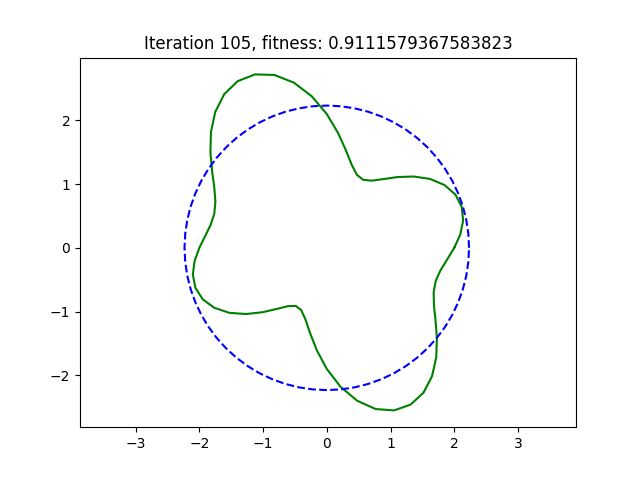

In [48]:
if DIM_2D:
    fig, ax = plt.subplots(1,1)
    ax.axis('equal')
    plt.ion()
    fig.show()
    fig.canvas.draw()
    plot_interactive_object = PlotInteractive2D(
        fig = fig,
        ax = ax,
        thetas = collocation.thetas_closed,
        r_exact_vals = R_EXACT(collocation.thetas_closed)
    )
else:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    # TODO: set axis limits automaticly
    ax.set_xlim3d([-3, 3])
    ax.set_ylim3d([-3, 3])
    ax.set_zlim3d([-3, 3])
    plot_interactive_object = PlotInteractive3D(
        fig = fig,
        ax = ax,
        thetas = collocation.thetas,
        phis = collocation.phis_closed,
        r_exact_vals = R_EXACT(thetas_mesh, phis_mesh)
    )

%matplotlib inline
toolbox.register("plot", plot_approximation, plot_interactive = plot_interactive_object)

## Define execution model

In [49]:
def rModel(Npop, Ngen, Pcross, Pmut, rng, MaxNoImprove = 100, guesses = None, checkpointFreq = 200):    
    # Optimal coeeficient is 40% of population size.
    # See "Zbigniew Michalewicz Genetic Algorithms + Data structures = Evolutions Programs"
    changeSize = int(0.4*Npop)
    
    ## Insert initial guesses if given
    if(guesses is None):
        population = toolbox.population(n=Npop)
    else:
        population = toolbox.population(n=Npop-len(guesses))
        population.extend(guesses)
    
    # Saves best individual
    hof = tools.HallOfFame(5)
    
    # Define statistics
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(lambda ind: ind.height)
    
    stats = tools.MultiStatistics(fitness=stats_fit, height=stats_size)
    
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    logbook = tools.Logbook()
    
    logbook.header = "gen", "evals", "fitness", "height"
    logbook.chapters["fitness"].header = "min", "avg", "max", "std"
    logbook.chapters["height"].header = "min", "avg", "max"
    
    # Evaluate the entire population
    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind)
        
    # Update hof
    hof.update(population)
    
    # Register logbook
    record = stats.compile(population)
    logbook.record(gen=0, evals=len(population), **record)
    
    # Print progress
    print(logbook.stream)
    
    no_improve_iter = 0
    best_fitness = 1e5
    
    for generation in range(1, Ngen):
        
        # Select parents and copy them to offspring
        parents = toolbox.select_tournament(population, changeSize)
        
        offspring = [toolbox.clone(ind) for ind in parents]
        
        # Select died elements and remove them from population
        to_die = toolbox.select_worst(population, changeSize)
        
        population = [ind for ind in population if not any(ind is copy for copy in to_die)]
        

        # Apply crossover and mutation to create offspring
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if rng.random() < Pcross:
                ind1,ind2 = toolbox.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        for ind in offspring:
            if rng.random() < Pmut:
                ind, = toolbox.mutate(ind)
                del ind.fitness.values
        

        # Evaluate the individuals with an invalid fitness
        invalids = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalids:
            ind.fitness.values = toolbox.evaluate(ind)
        
        # Replacement of the population by the offspring
        population.extend(offspring)
        
        hof.update(population)
        
        record = stats.compile(population)
        logbook.record(gen=generation, evals=len(invalids), **record)
        
        print(logbook.stream)
        
#         ## make checkpoint
#         if generation % checkpointFreq == 0:
#             now = datetime.now()
#             cp = dict(population=population, generation=generation, halloffame=hof,
#                       logbook=logbook, rndstate=rng.get_state())
#             with open(f'{now.strftime("%d-%m-%Y_%H-%M-%S")}.pkl', "wb") as cp_file:
#                 pickle.dump(cp, cp_file)
        
        if hof[0].fitness.values[0] < best_fitness:
            no_improve_iter = 0
            best_fitness = hof[0].fitness.values[0]
            
            # Plot current solution
            toolbox.plot(hof[0],title = f'Iteration {generation}, fitness: {hof[0].fitness.values[0]}')
        else:
            no_improve_iter+=1
            
        
        if no_improve_iter > MaxNoImprove:
            break
        
    return population, logbook, hof

In [50]:
def simpleModel(Npop, Ngen, Pcross, Pmut, rng, MaxNoImprove = 100, guesses = None, checkpointFreq = 200):
    
    ## Insert initial guesses if given
    if(guesses is None):
        population = toolbox.population(n=Npop)
    else:
        population = toolbox.population(n=Npop-len(guesses))
        population.extend(guesses)
    
    # Saves best individual
    hof = tools.HallOfFame(5)
    
    # Define statistics
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(lambda ind: ind.height)
    
    stats = tools.MultiStatistics(fitness=stats_fit, height=stats_size)
    
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    logbook = tools.Logbook()
    
    logbook.header = "gen", "evals", "fitness", "height"
    logbook.chapters["fitness"].header = "min", "avg", "max", "std"
    logbook.chapters["height"].header = "min", "avg", "max"
    
    # Evaluate the entire population
    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind)
        
    # Update hof
    hof.update(population)
    
    # Register logbook
    record = stats.compile(population)
    logbook.record(gen=0, evals=len(population), **record)
    
    # Print progress
    print(logbook.stream)
    
    no_improve_iter = 0
    best_fitness = 1e5
    
    for generation in range(1, Ngen):
        
        offspring = toolbox.select_tournament(population, len(population))
        
        offspring = [toolbox.clone(ind) for ind in offspring]        

        # Apply crossover and mutation to create offspring
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if rng.random() < Pcross:
                ind1,ind2 = toolbox.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        for ind in offspring:
            if rng.random() < Pmut:
                ind, = toolbox.mutate(ind)
                del ind.fitness.values
        

        # Evaluate the individuals with an invalid fitness
        invalids = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalids:
            ind.fitness.values = toolbox.evaluate(ind)
        
        # Replacement of the population by the offspring
        population[:] = offspring
        
        hof.update(population)
        
        record = stats.compile(population)
        logbook.record(gen=generation, evals=len(invalids), **record)
        
        print(logbook.stream)
        
        if hof[0].fitness.values[0] < best_fitness:
            no_improve_iter = 0
            best_fitness = hof[0].fitness.values[0]
            
            # Plot current solution
            toolbox.plot(hof[0],title = f'Iteration {generation}, fitness: {hof[0].fitness.values[0]}')
        else:
            no_improve_iter+=1
            
        
        if no_improve_iter > MaxNoImprove:
            break
        
    return population, logbook, hof

In [51]:
def guess_few(rng, n_guess = 10):
    top_selected = []
    for _ in range(n_guess):
        population, logbook, hof =  rModel(Npop = 200,
                                      Ngen = 500,
                                      Pcross = 0.2,
                                      Pmut = 0.8,
                                      rng = rng )
        top_selected.extend(hof)
    return top_selected

In [52]:
random_generator = np.random.default_rng()

In [53]:
if __name__ == "__main__":
    population, logbook, hof = rModel(Npop = 500,
                                  Ngen = 1000,
                                  Pcross = 0.7,
                                  Pmut = 0.35,
                                  rng = random_generator,
                                  MaxNoImprove = 100)
#     population, logbook, hof = simpleModel(Npop = 500,
#                                   Ngen = 1000,
#                                   Pcross = 0.6,
#                                   Pmut = 0.15,
#                                   rng = random_generator,
#                                   MaxNoImprove = 100)
    
#     initial_guesses = guess_few(random_generator, 10)
#     population, logbook, hof = rModel(Npop = 1000,
#                                       Ngen = 500,
#                                       Pcross = 0.7,
#                                       Pmut = 0.35,
#                                       rng = random_generator,
#                                       guesses = initial_guesses,
#                                      MaxNoImprove = 300)


   	     	            fitness            	       height      
   	     	-------------------------------	-------------------
gen	evals	min    	avg    	max   	std    	min	avg  	max
0  	500  	1.21678	901.768	100568	6453.35	1  	2.672	5  
1  	166  	1.21678	124.035	9335.61	480.551	0  	2.532	9  
2  	150  	1.21678	92.7644	1609.24	123.777	0  	2.458	11 
3  	157  	0.999315	99.1253	4844.33	322.517	0  	2.254	11 
4  	156  	0.981034	624.387	260990 	11701.1	0  	1.914	9  
5  	158  	0.981034	36.3573	2971.62	163.409	0  	1.538	7  
6  	155  	0.9118  	18.6859	714.09 	51.1092	0  	1.476	7  
7  	157  	0.9118  	19.9348	1501.56	86.1961	0  	1.602	8  
8  	151  	0.9118  	70.8796	16650.5	778.094	0  	2.018	8  
9  	151  	0.9118  	44.8325	2789.88	194.448	0  	2.638	7  
10 	150  	0.9118  	40.7848	3352.94	240.913	0  	2.734	8  
11 	168  	0.9118  	21.8073	979.407	79.5069	0  	2.82 	8  
12 	166  	0.9118  	36.9589	3074.54	165.337	1  	3.036	9  
13 	154  	0.911403	28.3462	1513.21	125.645	0  	3.092	8  
14 	162  	0.911403	37.155 	

141	154  	0.911158	19.6295	1739.05	89.5105	1  	6.406	23 
142	159  	0.911158	20.3424	804.383	65.3185	1  	6.204	21 
143	156  	0.911158	20.6953	1096.01	77.8232	0  	6.36 	21 
144	165  	0.911158	22.9369	804.383	66.6796	0  	6.28 	21 
145	170  	0.911158	47.5025	8389.79	405.788	1  	6.32 	21 
146	159  	0.911158	16.5916	265.007	37.2752	1  	6.48 	21 
147	162  	0.911158	25.054 	1739.05	98.1219	1  	6.488	22 
148	157  	0.911158	23.7881	1739.05	93.2006	0  	6.522	22 
149	156  	0.911158	17.0038	316.769	38.5389	1  	6.708	23 
150	140  	0.911158	18.4316	804.383	69.2637	1  	6.912	25 
151	163  	0.911158	21.4589	804.383	52.7634	0  	6.986	25 
152	145  	0.911158	48.2328	15959.7	713.353	1  	7.178	25 
153	166  	0.911158	36.871 	4676.99	251.627	1  	7.444	25 
154	161  	0.911158	20.6992	2841.32	132.714	1  	7.542	25 
155	153  	0.911158	20.0266	1527   	79.8725	1  	7.83 	28 
156	142  	0.911158	18.3546	894.153	66.3918	1  	7.848	30 
157	168  	0.911158	23.5162	804.383	64.8096	0  	7.724	30 
158	152  	0.911158	24.6699	804.

In [54]:
print(hof[0])

neg(neg(pow4(protectedSqrt(pow4(protectedSqrt(pow4(protectedSqrt(e))))))))


In [55]:
for e in hof:
    print(e)
    print('\n')

neg(neg(pow4(protectedSqrt(pow4(protectedSqrt(pow4(protectedSqrt(e))))))))


neg(neg(pow4(protectedSqrt(pow4(protectedSqrt(e))))))


neg(neg(pow4(protectedSqrt(neg(e)))))


neg(neg(pow4(protectedSqrt(neg(neg(e))))))


neg(neg(pow4(protectedSqrt(e))))


